In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
from cmapPy.pandasGEXpress import parse

In [57]:
sig_info.pert_type.unique()

array(['ctl_vehicle', 'trt_cp', 'ctl_untrt', 'trt_sh.cgs',
       'ctl_vehicle.cns', 'ctl_vector.cns', 'ctl_untrt.cns', 'trt_sh.css',
       'trt_lig', 'ctl_vector', 'trt_sh', 'trt_oe', 'trt_oe.mut'], dtype=object)

In [3]:
filepath ='GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx'
siginfopath = 'GSE92742_Broad_LINCS_sig_info.txt'
siginfopath = 'GSE92742_Broad_LINCS_sig_info.txt'
geneinfopath = 'GSE92742_Broad_LINCS_gene_info.txt'

sig_info = pd.read_csv(siginfopath, sep="\t")
gene_info = pd.read_csv(geneinfopath, sep="\t")

landmark_genes = gene_info[gene_info.pr_is_lm == 1].pr_gene_symbol.unique()

landmark_sigs = []
for i in range(len(sig_info)):
    if i % 50000 == 0:
        print(i, 'of', len(sig_info))
    col_gene_symbol = sig_info.pert_iname.iloc[i]
    if col_gene_symbol in landmark_genes:
            landmark_sigs.append(sig_info.iloc[i])
landmark_sigs = pd.DataFrame(landmark_sigs)
sh_rna_sigs = landmark_sigs['sig_id'][landmark_sigs['pert_type'] == 'trt_sh']

/home/nate/bin/anaconda3/envs/cmap/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(0, 'of', 473647)
(50000, 'of', 473647)
(100000, 'of', 473647)
(150000, 'of', 473647)
(200000, 'of', 473647)
(250000, 'of', 473647)
(300000, 'of', 473647)
(350000, 'of', 473647)
(400000, 'of', 473647)
(450000, 'of', 473647)


In [38]:
out_csv = 'sh_rna_data_frame.csv'
jump_size = 5000
t = 0
j = jump_size

In [39]:
promoters = {}
repressors = {}

num_to_save = 10
while t <= len(sh_rna_sigs):
    print(j, 'of', len(sh_rna_sigs))
    sh_rna_sigs_subset = sh_rna_sigs[t:min(j, len(sh_rna_sigs))]
    sh_rna_gctoo = parse(filepath, cid=sh_rna_sigs_subset, convert_neg_666=True)
    sh_rna_gctoo.data_df.to_csv(path_or_buf=out_csv)
    df = pd.read_csv(out_csv)
    for i in range(1, len(df.columns)):
        col_name = df.columns[i]
        col = df[col_name]
        col_gene_symbol = sig_info[sig_info.sig_id == col_name].pert_iname.iloc[0]

        for _ in range(num_to_save):
            min_i = col.idxmin()
            max_i = col.idxmax()
            min_gene_id = df[min_i:min_i+1].rid.iloc[0]
            max_gene_id = df[max_i:max_i+1].rid.iloc[0]

            min_gene_symbol = gene_info[gene_info.pr_gene_id == min_gene_id].pr_gene_symbol.iloc[0]
            max_gene_symbol = gene_info[gene_info.pr_gene_id == max_gene_id].pr_gene_symbol.iloc[0]
            
            k_min = (col_gene_symbol, min_gene_symbol)
            k_max = (col_gene_symbol, max_gene_symbol)
            if k_min not in promoters:
                promoters[k_min] = []
            if k_max not in repressor:
                repressors[k_max] = []
            
            # promotion and repression are swapped
            promoter_score = df.loc[min_i, col_name]
            repressor_score = df.loc[max_i, col_name]
            promoters[k_min].append(promoter_score)
            repressors[k_max].append(repressor_score)
            
            df.loc[max_i, col_name] = 0.0
            df.loc[min_i, col_name] = 0.0
    t += jump_size
    j += jump_size

(5000, 'of', 51255)
(10000, 'of', 51255)
(15000, 'of', 51255)
(20000, 'of', 51255)
(25000, 'of', 51255)
(30000, 'of', 51255)
(35000, 'of', 51255)
(40000, 'of', 51255)
(45000, 'of', 51255)
(50000, 'of', 51255)
(55000, 'of', 51255)


In [40]:
import json

with open('promoters.json', 'w') as w:
    json.dump(promoters, w)
with open('repressors.json', 'w') as w:
    json.dump(repressors, w)
sh_rna_gctoo = None
df = None
sh_rna_sigs_subset = None

In [41]:
print(len(promoters))
print(len(repressors))

946
946


In [54]:
import collections

s = 0
max_count = 0
for k, v in promoters.items():
    s += len(v)
    counter = collections.Counter(v)
    if counter.most_common(1)[0][1] > max_count:
        max_count = counter.most_common(1)[0][1]
        if max_count == 176:
            print(counter.most_common(1))
    
for k, v in repressors.items():
    s += len(v)
    counter = collections.Counter(v)
    if counter.most_common(1)[0][1] > max_count:
        max_count = counter.most_common(1)[0][1]
print(max_count)

[('BAD', 176)]
176


In [ ]:
header = '''digraph G {
'''
footer = '''}'''
graph_spec = ''
graph_spec += header
for regulator, promoted in promoters:
    regulator = regulator.replace('-', '_')
    promoted = promoted.replace('-', '_')
    graph_spec += '\t{A} -> {B};\n'.format(A=regulator, B=promoted)
for regulator, repressed in repressors:
    regulator = regulator.replace('-', '_')
    repressed = repressed.replace('-', '_')
    graph_spec += '\t{A} -> {B};\n'.format(A=regulator, B=repressed)
graph_spec += footer
out_gv = 'sh_rna_graph.gv'
with open(out_gv, 'w') as w:
    w.write(graph_spec)
from subprocess import call
call(['dot', out_gv, '-Tpng', '-o', 'sh_rna_graph.png'])

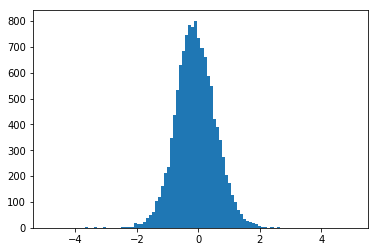

('MIN', -4.8808431625399997, 139)
('MAX', 5.0153727531400003, 1712)


In [129]:
# TODO: Ignore first columns as it's the rid?
i = 5
to_plot = df[df.columns[i]]
plt.hist(to_plot, bins=100)
plt.show()
print('MIN', to_plot.min(), to_plot.idxmin())
print('MAX', to_plot.max(), to_plot.idxmax())
rid = df[0:1].rid.iloc[0]

226